# Infinite Blackjack

This notebook covers Example 5.1 and 5.3 of http://people.inf.elte.hu/lorincz/Files/RL_2006/SuttonBook.pdf .

We consider a variant of a Blackjack game where cards are dealt from an infinite deck. This makes the problem easier, because we do not need to keep track of cards already dealt.

In [1]:
# imports
import math
import numpy as np
import random
from collections import defaultdict, namedtuple
from enum import Enum
import itertools
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
random.seed(13531)

In [3]:
BlackjackState = namedtuple('BlackjackState', ['player_sum', 'dealer_shown', 'has_usable_ace'])

In [4]:
class BlackjackAction(Enum):
    HIT = 0
    STICK = 1

In [5]:
def draw_card_value():
    """Draw a random card, and return its value.
    """
    card_index = random.randint(1, 13)
    return card_index if card_index <= 10 else 10

In [6]:
def play_episode(initial_state, policy, verbose=True, first_action=None):
    """Play a Blackjack episode following the given policy.
    
    Returns a triple: (return value, list of states, list of player actions)    
    """
    def msg(text):
        if verbose:
            print(text)
        else:
            pass
    
    state_list = []
    action_list = []
        
    # the player plays first
    current_state = initial_state
    is_first = True
    while True:
        msg("current state: {:}".format(current_state))
        state_list.append(current_state)
        
        if is_first and (first_action is not None):
            now_action = first_action
        else:
            now_action = policy(current_state)
        if is_first:
            is_first = False            
        if verbose:
            msg("player's action: {:}".format(now_action))        
        action_list.append(now_action)
        
        if now_action == BlackjackAction.HIT:
            new_card_value = draw_card_value()
            if verbose:
                msg("player's new card value: {:d}".format(new_card_value))
            new_player_sum = current_state.player_sum + new_card_value
            if new_player_sum > 21:
                if current_state.has_usable_ace:
                    new_player_sum -= 10
                    current_state = BlackjackState(player_sum=new_player_sum,
                                                   dealer_shown=current_state.dealer_shown,
                                                   has_usable_ace=False)
                else:
                    if verbose:
                        msg("player busts!!!")
                    return -1, state_list, action_list
            else:
                current_state = BlackjackState(player_sum=new_player_sum,
                                               dealer_shown=current_state.dealer_shown,
                                               has_usable_ace=current_state.has_usable_ace)
        else:
            assert now_action == BlackjackAction.STICK
            break
    
    # now the dealer plays
    if initial_state.dealer_shown == 1:
        dealer_sum = 11
        dealer_has_usable_ace = True
    else:
        dealer_sum = initial_state.dealer_shown
        dealer_has_usable_ace = False
    
    # dealer's strategy is fixed
    while dealer_sum < 17:
        new_card_value = draw_card_value()
        msg("dealer's new card: {}, dealer has ace: {}".format(new_card_value, dealer_has_usable_ace))
        dealer_sum += new_card_value
        if dealer_sum > 21 and dealer_has_usable_ace:
            dealer_sum -= 10
            dealer_has_usable_ace = False
    
    msg("dealer's final sum: {}".format(dealer_sum))
    if dealer_sum > 21:
        return_value = 1
    else:
        dealer_gap = abs(dealer_sum - 21)
        player_gap = abs(current_state.player_sum - 21)
        if player_gap < dealer_gap:
            return_value = 1
        elif player_gap > dealer_gap:
            return_value = -1
        else: # player_gap == dealer_gap           
            return_value = 0
            
    return return_value, state_list, action_list

In [7]:
def sample_state():
    return BlackjackState(player_sum=random.randint(11, 21), dealer_shown=random.randint(1, 10),
                          has_usable_ace=random.random() < 0.5)

## Example 5.1. Monte carlo evaluation of naive policy

Let us evaluate the efficacy of naive policy, which sticks only if the current sum is greater than 20.

In [8]:
def naive_policy(state):
    if state.player_sum >= 20:
        return BlackjackAction.STICK
    else:
        return BlackjackAction.HIT

In [9]:
def monte_carlo_policy_evaluation(iter_num=1000, policy=naive_policy):
    state_to_value_samples = defaultdict(list)
    for iter_index in range(iter_num):
        return_value, states, actions = play_episode(sample_state(), policy, verbose=False)
        for state in states:
            state_to_value_samples[state].append(return_value)
    return state_to_value_samples

In [10]:
def monte_carlo_draw_contour(has_usable_ace, iter_num=10000, policy=naive_policy):
    state_to_value_samples = monte_carlo_policy_evaluation(iter_num=iter_num)
    has_usable_ace = False
    xs, ys = np.meshgrid(range(12, 22), range(1,11))
    zs = np.zeros(xs.shape)
    for i in range(xs.shape[0]):
        for j in range(xs.shape[1]):
            player_sum = xs[i, j]
            dealer_shown = ys[i, j]
            zs[i,j] = np.mean(state_to_value_samples[BlackjackState(player_sum, dealer_shown, has_usable_ace)])

    plt.contourf(xs, ys, zs)
    plt.xlabel('player sum')
    plt.ylabel('dealer shown (1: ace)')
    plt.colorbar()
    plt.show()

### Figure 5.2. When the player has a usable ace

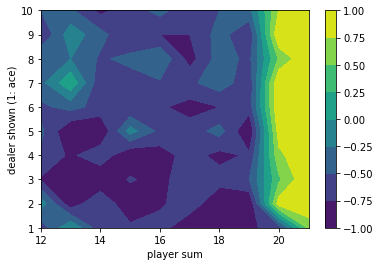

In [11]:
monte_carlo_draw_contour(has_usable_ace=True, iter_num=1000)

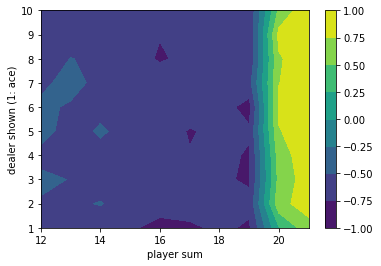

In [12]:
monte_carlo_draw_contour(has_usable_ace=True, iter_num=10000)

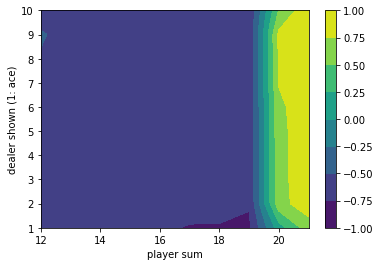

In [13]:
monte_carlo_draw_contour(has_usable_ace=True, iter_num=500000)

### Figure 5.2. When the player does not have a usable ace

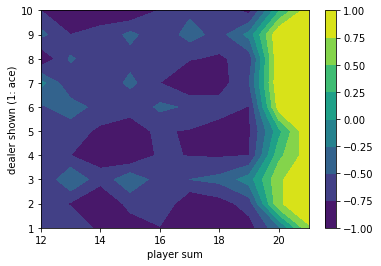

In [14]:
monte_carlo_draw_contour(has_usable_ace=False, iter_num=1000)

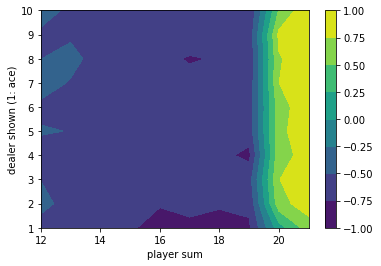

In [15]:
monte_carlo_draw_contour(has_usable_ace=False, iter_num=10000)

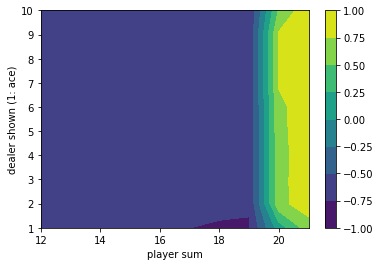

In [16]:
monte_carlo_draw_contour(has_usable_ace=False, iter_num=500000)

## Example 5.3. Monte Carlo Control with Exploring Starts

Now, let us find the optimal policy using Monte Carlo Control with Exploring Starts.

In [17]:
def monte_carlo_control(iter_num=1000):
    state_action_to_value_means = defaultdict(float)
    state_action_to_counts = defaultdict(int)
    
    def monte_carlo_policy(state):
        hit_value = state_action_to_value_means[(state, BlackjackAction.HIT)]
        stick_value = state_action_to_value_means[(state, BlackjackAction.STICK)]
        
        if hit_value > stick_value:
            return BlackjackAction.HIT
        else:
            return BlackjackAction.STICK
    
    for iter_index in range(iter_num):
        if iter_index > 0 and iter_index % 10000 == 0:
            print("currently at: {:d}/{:d}".format(iter_index, iter_num))
        start_state = sample_state()
        start_action = BlackjackAction.HIT if random.random() < 0.5 else BlackjackAction.STICK
        
        return_value, states, actions = play_episode(start_state, monte_carlo_policy, 
                                                     verbose=False, first_action=start_action)
        for state, action in zip(states, actions):
            state_action_to_counts[(state, action)] += 1
            state_action_to_value_means[(state, action)] += ((return_value - 
                                                              state_action_to_value_means[(state, action)])/
                                                             state_action_to_counts[(state, action)])
                
            
    return state_action_to_value_means, state_action_to_counts, monte_carlo_policy

In [18]:
# this takes quite a bit of time...
state_action_to_value_means, state_action_to_counts, monte_carlo_policy = monte_carlo_control(1000000)

currently at: 10000/1000000
currently at: 20000/1000000
currently at: 30000/1000000
currently at: 40000/1000000
currently at: 50000/1000000
currently at: 60000/1000000
currently at: 70000/1000000
currently at: 80000/1000000
currently at: 90000/1000000
currently at: 100000/1000000
currently at: 110000/1000000
currently at: 120000/1000000
currently at: 130000/1000000
currently at: 140000/1000000
currently at: 150000/1000000
currently at: 160000/1000000
currently at: 170000/1000000
currently at: 180000/1000000
currently at: 190000/1000000
currently at: 200000/1000000
currently at: 210000/1000000
currently at: 220000/1000000
currently at: 230000/1000000
currently at: 240000/1000000
currently at: 250000/1000000
currently at: 260000/1000000
currently at: 270000/1000000
currently at: 280000/1000000
currently at: 290000/1000000
currently at: 300000/1000000
currently at: 310000/1000000
currently at: 320000/1000000
currently at: 330000/1000000
currently at: 340000/1000000
currently at: 350000/10

### Figure 5.5. The opimal policy when the player has a usable ace

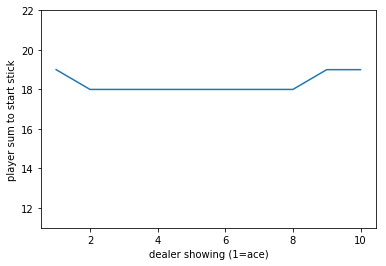

In [19]:
has_usable_ace = True
xs = []
ys = []
for dealer_shown in range(1,11):
    stick_threshold = 0
    for player_sum in range(11, 22):
        if monte_carlo_policy(BlackjackState(player_sum, dealer_shown, has_usable_ace)) == BlackjackAction.STICK:
            stick_threshold = player_sum
            break
    xs.append(dealer_shown)
    ys.append(stick_threshold)
plt.plot(xs, ys)
plt.ylim(11, 22)
plt.xlabel('dealer showing (1=ace)')
plt.ylabel('player sum to start stick')
plt.show()

### Figure 5.5. The opimal policy when the player does not have a usable ace

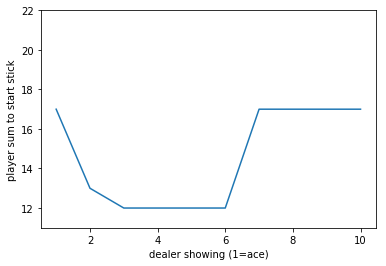

In [20]:
has_usable_ace = False
xs = []
ys = []
for dealer_shown in range(1,11):
    stick_threshold = 0
    for player_sum in range(11, 22):
        if monte_carlo_policy(BlackjackState(player_sum, dealer_shown, has_usable_ace)) == BlackjackAction.STICK:
            stick_threshold = player_sum
            break
    xs.append(dealer_shown)
    ys.append(stick_threshold)
plt.plot(xs, ys)
plt.ylim(11, 22)
plt.xlabel('dealer showing (1=ace)')
plt.ylabel('player sum to start stick')
plt.show()